# Clustering Brands

### Imports

In [1]:
from datetime import datetime
import random
from itertools import combinations
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import SpectralClustering
import networkx as nx
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

### Global Variables

In [2]:
global BRANDS_LIST              #List of Brand Names
global BRAND_FOLLOWERS          #Dictionary[Brand] =  [Brand Followers]
global C_DIST_MAT               #Condensed Distance Matrix 
global DIST_MAT                 #Distance Matrix
global Z
global CLUSTERS                 #Dictionary of Clusters
global N_BRANDS                 #Number of Brands
global N_CLUSTERS               #Number of Clusters

### Parameters

In [3]:
MAX_ROWS = 1404    #Maximum number of lines in file
N_BRANDS = 250     #Number of Brands
N_CLUSTERS = 8     #Number of Clusters

### Quickfix for preparing data

In [4]:
def check_data_file():
    import os.path
    if os.path.exists('brand_followers.tsv'):     # Do not run this more than more
        out_file = open("brand_followers_fixed.tsv","w")
        with open('brand_followers.tsv','r') as data_file:
            data = data_file.read()
            data = data.replace('1114073faithhill','1114073\nfaithhill')
            out_file.write(data)
        out_file.close()
        os.remove('brand_followers.tsv')
        return True
    elif os.path.exists('brand_followers_fixed.tsv'):
        #out_file = open("brand_followers_fixed.tsv","w")
        #with open('brand_followers_final.tsv','r') as data_file:
            #data = data_file.read()
            #followers = data.split()
            #if len(followers) > 50:
                #out_file.write(data)
        #out_file.close()
        #os.remove('brand_followers_final.tsv')
        return True
    elif os.path.exists('brand_followers_final.tsv'):
        return True
    return False

In [5]:
if check_data_file():
    print('Data file is ready for use.')
else:
    print('Oops! Something went wrong here. Data file is not ready.')

Data file is ready for use.


### Load required data to memory

In [6]:
def load_data(number_of_brands_to_load=MAX_ROWS, verbose=False):
    global BRANDS_LIST
    global BRAND_FOLLOWERS
    global N_BRANDS
    global G
    
    
    start = datetime.now()    
    BRAND_FOLLOWERS = {}
    BRANDS_LIST = []
    G = nx.Graph()
        
    # Selecting random brands to load
    if number_of_brands_to_load!= MAX_ROWS:
        choices = random.sample(range(1,MAX_ROWS), number_of_brands_to_load)
        max_row_id = max(choices)
    else:
        choices = xrange(1,MAX_ROWS)
        max_row_id = MAX_ROWS
        
    row_id = 0  #Line number
    skipped = 0 #to track number of lines skip
    
    with open('brand_followers_final.tsv') as data_file:
        for row in data_file:
            row_id += 1
            if row_id in choices: #Randomly selecting brands
                followers = row.split()
                brand = followers.pop(0)
                if len(followers) > 50:  #Filtering brands with less than 50 followers
                    BRAND_FOLLOWERS[brand] = set([int(x) for x in followers])
                    BRANDS_LIST.append(brand)
                    G.add_node(brand)
                    if verbose:
                        print('Added',brand,'- Followers:',len(followers))
                else:
                    skipped +=1
                    if verbose:
                        print('Skipped',brand,'- Followers:',len(followers))
                
                if row_id == MAX_ROWS or row_id==max_row_id:
                    stop = datetime.now()
                    N_BRANDS = number_of_brands_to_load - skipped
                    print('Loaded',N_BRANDS, 'rows in time',stop-start)
                    break
    return

In [7]:
load_data(N_BRANDS, verbose=True)

Added 34degrees - Followers: 1773
Added acne_free_skin - Followers: 2090
Added act - Followers: 5028
Added acti_pr - Followers: 3315
Added acura_insider - Followers: 57961
Added acureorganics - Followers: 3304
Added alaffiaskincare - Followers: 1133
Added allure_magazine - Followers: 269437
Added always - Followers: 4241
Added amanabrand - Followers: 9472
Added american_girl - Followers: 5910
Added angelicastiffy - Followers: 1465
Added anntaylor - Followers: 60117
Added anthropologie - Followers: 467286
Added aphroditegy - Followers: 3618
Added aquafina - Followers: 1724
Added artistrybeauty - Followers: 44269
Added astonmartin - Followers: 280585
Added att - Followers: 491760
Added avoninsider - Followers: 75358
Added babyganics - Followers: 3880
Added bar35 - Followers: 3307
Added barbasolshave - Followers: 1683
Added bayer - Followers: 38273
Added beauticontrol - Followers: 3381
Added benandjerrys - Followers: 223389
Added bertolli - Followers: 12396
Added bestfoods - Followers: 19

### Computes the Distance Matrix

In [8]:
def compute_distance_matrix():
    global BRANDS_LIST
    global BRAND_FOLLOWERS
    global C_DIST_MAT
    global DIST_MAT
    global N_BRANDS
    global G
    
    start = datetime.now()
    DIST_MAT = np.zeros((N_BRANDS,N_BRANDS))
    C_DIST_MAT = []
    
    edges = 0
    
    for tuple_pair in combinations(enumerate(BRANDS_LIST),2):
        #tuple_pair = (b1_idx, b1_name)(b2_idx, b2_name)
        b1 = BRAND_FOLLOWERS[tuple_pair[0][1]]
        b2 = BRAND_FOLLOWERS[tuple_pair[1][1]]
        
        #Jaccard Similarity Measure
        common_connections = len(b1.intersection(b2))
        total_connections = len(b1) + len(b2) - common_connections #More efficient than set(b1).union(b2)
        weight = common_connections/total_connections

        #Condensed Distance Matrix
        C_DIST_MAT.append(1.0 - weight)
        
        #Symmetrix Distance Matrix
        DIST_MAT[tuple_pair[0][0] , tuple_pair[1][0]] = DIST_MAT[tuple_pair[1][0] , tuple_pair[0][0]] = 1.0 - weight
        
        #Graph
        if weight != 0.0:
            G.add_edge(tuple_pair[0][1],tuple_pair[1][1], weight = weight)
        
        edges += 1
        if edges%80000 == 0:
            print(edges, 'edges loaded.')
        
    stop = datetime.now()
    
    print('Created',N_BRANDS * (N_BRANDS-1),'Condensed Distance Matrix')
    print('Created',N_BRANDS,'x',N_BRANDS,'Distance Matrix')
    print('Created Graph of',G.number_of_nodes(),'nodes with',G.number_of_edges(),'edges')
    
    print('Elapsed Time',stop-start)
    
    #Freeing Memory - No point in heavy lifting after this point for the current implementation
    BRAND_FOLLOWERS = {}
    
    return

In [9]:
compute_distance_matrix()

Created 61256 Condensed Distance Matrix
Created 248 x 248 Distance Matrix
Created Graph of 248 nodes with 27045 edges
Elapsed Time 0:00:38.599953


### Clusters the given brands based on different Clustering Algorithms

In [10]:
def cluster_brands(method, num_clusters=N_CLUSTERS, linkage='complete', **kwargs):
    global C_DIST_MAT
    global BRANDS_LIST
    global Z
    global DIST_MAT
    global N_CLUSTERS
    global G
    
    #linkage = ['single', 'complete', 'average', 'weighted']
    
    start = datetime.now()
    
    if method =='Agglomerative':
        print('Clustering Algorithm: Agglomerative (complete)')
        clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage=linkage).fit(DIST_MAT)
        labels = clustering.labels_
        get_clusters(clustering.labels_, kwargs['print_clusters'], kwargs['print_cluster_size'])
        
    elif method =='Hierarchical':
        print('Clustering Algorithm: Hierarchical (complete)')
        Z = sch.linkage(C_DIST_MAT, method=linkage)
        labels = sch.fcluster(Z,kwargs['threshold'])  #threshold = 0.99999999
        get_clusters(labels, kwargs['print_clusters'], kwargs['print_cluster_size'])
        
        if kwargs['print_dendrogram']:
            #plt.clf()
            if N_BRANDS > 1000:
                fig = plt.figure(figsize=(100,100))
            else:
                fig = plt.figure()
            dd = sch.dendrogram(Z, labels=BRANDS_LIST,orientation='right')
            plt.savefig('figures/{}.png'.format(method))
        
    elif method == 'Spectral':
        print('Clustering Algorithm: Spectral (arpack,kmeans)')
        clustering = SpectralClustering(n_clusters=num_clusters, affinity='precomputed',
                                       eigen_solver='arpack', assign_labels='kmeans').fit(DIST_MAT)
        labels = clustering.labels_
        get_clusters(clustering.labels_, kwargs['print_clusters'], kwargs['print_cluster_size'])
    elif method == 'Girvan-Newman':
        print('Clustering Algorithm: Girvan-Newman')
        def most_central_edge(G):
            centrality = nx.edge_betweenness_centrality(G, weight='weight')
            return max(centrality, key=centrality.get)
        
        comp = nx.algorithms.community.girvan_newman(G, most_valuable_edge=most_central_edge)
        print('Clusters')
        for c in next(comp):
            print(c)

    stop = datetime.now()
    print('Clustering Completed in time',stop-start)
    
    return labels

### To generate the Cluster Dictionary and to display it

In [11]:
def get_clusters(cluster_labels, output, cluster_distribution=False, plot_in_2d=False):
    global CLUSTERS
    global N_BRANDS
    global BRANDS_LIST
    
    CLUSTERS = {}
    start = min(cluster_labels)
    stop = max(cluster_labels)
    
    #Initialize
    for i in range(start,stop+1):
        CLUSTERS[i] = []    
    
    #Cluster Dictionary
    for i in range(N_BRANDS):
        CLUSTERS[cluster_labels[i]].append(BRANDS_LIST[i])
    
    #Printing desired output
    if output=='LABEL':
        print('Displaying Clusters by labels...')
        for i in range(start,stop+1):
            print (i,':',CLUSTERS[i])
            
    elif output=='SIZE':
        print('Displaying Clusters by size...')
        for key in sorted(CLUSTERS, reverse=True, key=lambda k: len(CLUSTERS[k])):
            print (len(CLUSTERS[key]),'(',key,'):',CLUSTERS[key])

    #Visualize
    if plot_in_2d:
        plot_cluster_in_2d(cluster_labels)
    
    #Plot Cluster Size Distribution
    if cluster_distribution:
        plot_cluster_size()
        
    

### Scales the data points in 2D and plots based on its Cluster

In [12]:
def plot_cluster_in_2d(cluster_labels):
    from sklearn.manifold import MDS
    global DIST_MAT
    global BRANDS_LIST
    global N_BRANDS
    
    if min(cluster_labels) == 0:
        num_clusters = max(cluster_labels) + 1
    else:
        num_clusters = max(cluster_labels)
        

    print('Num Clusters:',num_clusters)
    
    if n_brands > 1000:
        fig = plt.figure(figsize=(100,100))
    else:
        fig = plt.figure()
    fig, ax = plt.subplots(figsize=(15,15))
    cmap = plt.get_cmap('jet')
    colors = cmap(np.linspace(0, 1, num_clusters))
    colors_map = []
    for i in range(N_BRANDS):
        colors_map.append(colors[cluster_labels[i]])
        
        
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    pos = mds.fit_transform(DIST_MAT)  # shape (n_components, n_samples)
    
    xs, ys = pos[:, 0], pos[:, 1]
    
    for i in range(N_BRANDS):
        ax.scatter(xs[i],ys[i],color=colors_map[i])
        ax.text(xs[i],ys[i],BRANDS_LIST[i])
    plt.savefig('figures/{}.png'.format('clusters'))

### Plots the size of each cluster

In [13]:
def plot_cluster_size():
    global CLUSTERS
    cluster_size_count = []
    
    for cluster_id in CLUSTERS:
        cluster_size_count.append(len(CLUSTERS[cluster_id]))
    
    plt.hist(cluster_size_count, bins = range(max(cluster_size_count)+1))
    plt.xlabel('Cluster Size')
    plt.ylabel('Count')
    plt.title('Cluster Size Distribution')
    plt.savefig('figures/{}.png'.format('cluster_size'))

### Plots Silhouette Scores for a Clustering

In [14]:
def plot_silhouette_scores(method, max_clusters=25):
    global DIST_MAT
    global Z
    scores = []
    fig = plt.figure()
    if method == 'Hierarchical':
        thresholds = []
        for i in range(60,100,5):
            thresholds.append(i/100.0)
            labels = sch.fcluster(Z,thresholds[-1])
            scores.append(metrics.silhouette_score(DIST_MAT, labels, metric='precomputed'))
        plt.scatter(thresholds,scores)
        plt.plot(thresholds,scores, marker='o')
        
    elif method == 'Agglomerative':
        num_clusters = range(2,max_clusters+1)
        linkage='complete'
        for cluster_size in num_clusters:
            clustering = AgglomerativeClustering(n_clusters=cluster_size, linkage=linkage).fit(DIST_MAT)
            labels = clustering.labels_
            scores.append(metrics.silhouette_score(DIST_MAT, labels, metric='precomputed'))
        plt.scatter(num_clusters,scores)
        plt.plot(num_clusters,scores, marker='o')
     
    elif method == 'Spectral':
        num_clusters = range(2,max_clusters+1)
        linkage='complete'
        for cluster_size in num_clusters:
            clustering = SpectralClustering(n_clusters=cluster_size, affinity='precomputed',
                                       eigen_solver='arpack', assign_labels='kmeans').fit(DIST_MAT)
            labels = clustering.labels_
            scores.append(metrics.silhouette_score(DIST_MAT, labels, metric='precomputed'))
        plt.scatter(num_clusters,scores)
        plt.plot(num_clusters,scores, marker='o')
        
    plt.savefig('figures/{}.png'.format(method+'_scores'))
            

### Girvan-Newman Algorithm

In [16]:
#clustering_method='Girvan-Newman'
#kwargs = {}
#cluster_brands(clustering_method, **kwargs)
#plot_silhouette_scores(clustering_method)

### 1. Agglomerative Clustering

Clustering Algorithm: Agglomerative (complete)
Displaying Clusters by labels...
0 : ['34degrees', 'acne_free_skin', 'act', 'acti_pr', 'acureorganics', 'alaffiaskincare', 'always', 'american_girl', 'angelicastiffy', 'aphroditegy', 'aquafina', 'artistrybeauty', 'avoninsider', 'bar35', 'barbasolshave', 'bayer', 'beauticontrol', 'bgcf', 'bigelowtea', 'bodyimage', 'braun', 'candiesbrand', 'caneandaustin', 'canidaepetfood', 'caribou_coffee', 'caswellmassey', 'celestialtea', 'chexcereal', 'cleanandclear', 'cobigelowny', 'coldeeze', 'colgate', 'countrychoice_', 'cwhairlondon', 'ddfskincare', 'delallofoods', 'dentek', 'dimpleskins', 'dpolaner', 'drinkcheerwine', 'drpraegers', 'ecotouchuk', 'edenfoods', 'elfcosmeticsuk', 'ellentracyny', 'empirekosher', 'essentiaphwater', 'eukanuba', 'evianwater', 'fagorindustrial', 'fancyfeast', 'farmland', 'foodsalive', 'fosterfarms', 'fusion_beauty', 'ge_reports', 'glutenfreeda', 'greenheritage', 'groominglounge', 'harneytea', 'hinoderice', 'homefreetreats', '

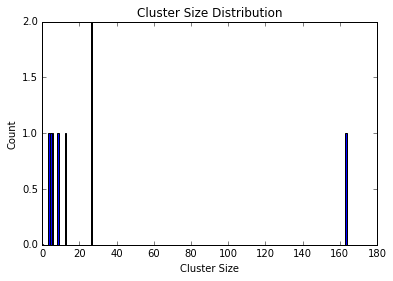

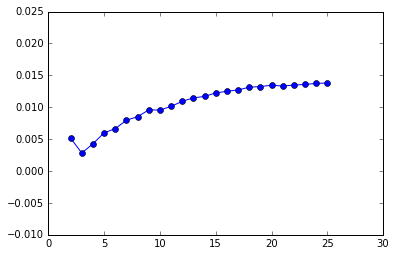

In [17]:
clustering_method='Agglomerative'
kwargs = {}
kwargs['print_clusters'] ='LABEL'
kwargs['print_cluster_size'] = True
cluster_brands(clustering_method, num_clusters= 8, **kwargs)
plot_silhouette_scores(clustering_method)

### 2. Hierarchical Clustering

Clustering Algorithm: Hierarchical (complete)
Displaying Clusters by labels...
1 : ['allure_magazine', 'bobatl', 'chanel', 'dell', 'ferragamo', 'hugoboss', 'jessicasimpson', 'michaelkors', 'nokia', 'redbull', 'versace', 'ysl']
2 : ['acura_insider', 'astonmartin', 'hyundai', 'lamborghini', 'lexus', 'mercedesbenz', 'thisisgmc', 'vw']
3 : ['benandjerrys', 'cocacolaco', 'dietcoke', 'dietpepsi', 'drpepper', 'mtn_dew']
4 : ['lgus', 'toshibausa']
5 : ['att', 'verizon', 'walgreens']
6 : ['bose', 'nautica']
7 : ['discover']
8 : ['anntaylor', 'anthropologie', 'oldspice']
9 : ['macrumors', 'realjaclynsmith', 'reallorraine', 'redcross', 'stephenrcovey']
10 : ['oomphband']
11 : ['bayer', 'medline']
12 : ['countrychoice_', 'kallarichoc', 'rococochocs', 'yorkchocfest']
13 : ['34degrees', 'drpraegers', 'farmrichsnacks', 'naturemade', 'nostalgiaelctrx', 'peeledsnacks']
14 : ['bertolli', 'bestfoods', 'ivory', 'pepto', 'reallunchables', 'roman_meal', 'smarties']
15 : ['delallofoods', 'juanitascocina']
16

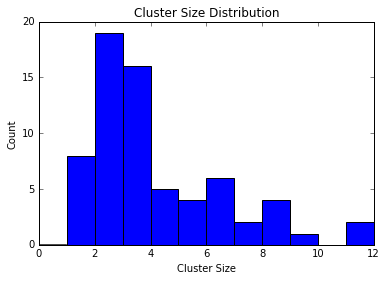

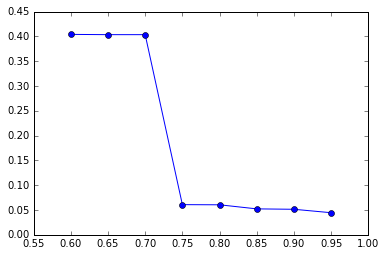

In [18]:
clustering_method='Hierarchical'
kwargs = {}
kwargs['print_clusters'] ='LABEL'
kwargs['print_cluster_size'] = True
kwargs['print_dendrogram'] = False
kwargs['threshold'] = 0.99999999
cluster_brands(clustering_method, num_clusters= 8, **kwargs)
plot_silhouette_scores(clustering_method)

### 3. Spectral Clustering

Clustering Algorithm: Spectral (arpack,kmeans)
Displaying Clusters by labels...
0 : ['34degrees', 'acne_free_skin', 'act', 'acti_pr', 'acura_insider', 'acureorganics', 'alaffiaskincare', 'allure_magazine', 'always', 'amanabrand', 'american_girl', 'angelicastiffy', 'anntaylor', 'anthropologie', 'aphroditegy', 'aquafina', 'artistrybeauty', 'att', 'avoninsider', 'babyganics', 'bar35', 'barbasolshave', 'bayer', 'beauticontrol', 'benandjerrys', 'bertolli', 'bestfoods', 'bgcf', 'bhcosmetics', 'bigelowtea', 'blue_bunny', 'bobatl', 'bodyimage', 'bose', 'braun', 'candiesbrand', 'caneandaustin', 'canidaepetfood', 'caribou_coffee', 'caswellmassey', 'celestialtea', 'chanel', 'chexcereal', 'cleanandclear', 'clinique_us', 'cobigelowny', 'cocacolaco', 'coldeeze', 'colgate', 'countrychoice_', 'cvsbeautyclub', 'cwhairlondon', 'dannon', 'ddfskincare', 'delallofoods', 'dell', 'delmonte', 'dentek', 'dietcoke', 'dietpepsi', 'digiornopizza', 'dimpleskins', 'discover', 'dove', 'dpolaner', 'drinkcheerwine', '

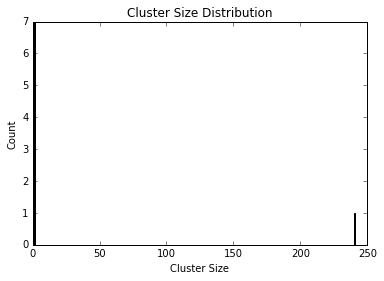

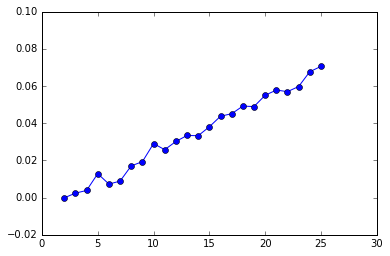

In [19]:
clustering_method='Spectral'
kwargs = {}
kwargs['print_clusters'] ='LABEL'
kwargs['print_cluster_size'] = True
cluster_brands(clustering_method, num_clusters= 8, **kwargs)
plot_silhouette_scores(clustering_method)